# Classification: Data Modeling

In [1]:
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import uniform

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

## Section 1: Term weighting with TF-IDF

In [2]:
target = '+Pertamina since:2022-09-03 until:2022-09-05 lang:in.csv'
supervised_target_path = f'../dataset/processed/supervised.{target}'

In [3]:
df = pd.read_csv(supervised_target_path, delimiter=';')
df.dropna(inplace=True)

df.head()

,content,tokens,tokens_ready,text,polarity,sentiment
0,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan...,"['bukti', 'pemerintahan', 'pro', 'rakyat', 'pr...","['bukti', 'perintah', 'pro', 'rakyat', 'pro', ...",bukti perintah pro rakyat pro oligarki vivo bb...,-2,0
1,"@KompasTV Mentri esdm, trus patokanmu apa? Kan...","['menteri', 'esdm', 'patokanmu', 'kantong', 'p...","['menteri', 'esdm', 'patok', 'kantong', 'perta...",menteri esdm patok kantong pertamina jebol kor...,-9,0
2,@hnurwahid Ngaku masih subsidi tapi ada swasta...,"['mengaku', 'subsidi', 'swasta', 'jual', 'mura...","['aku', 'subsidi', 'swasta', 'jual', 'murah', ...",aku subsidi swasta jual murah subsidi pertamin...,8,1
3,@Tan_Mar3M Kalau Vivo bisaberani bertahan deng...,"['vivo', 'berani', 'bertahan', 'harga', 'nasib...","['vivo', 'berani', 'tahan', 'harga', 'nasib', ...",vivo berani tahan harga nasib pertamina,4,1
4,Menteri BUMN Erick Thohir menegaskan persiapan...,"['menteri', 'bumn', 'erick', 'thohir', 'persia...","['menteri', 'bumn', 'erick', 'thohir', 'siap',...",menteri bumn erick thohir siap indonesia trans...,3,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=687)

In [5]:
vectorizer = TfidfVectorizer(use_idf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [6]:
# param_grid = {'C': [0.1, 1, 10],
#               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#               'degree': [1, 2, 3],
#               'gamma': ['auto', 'scale']}

param_grid = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': uniform(loc=0, scale=0.1)}

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

svm_model = svm.SVC()

grid_search = RandomizedSearchCV(svm_model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, random_state=0, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# grid_search = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=2, scoring='accuracy', return_train_score=True, verbose=1, callbacks=[early_stopping])
# grid_search.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x129c763b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x129c77be0>,
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=0, verbose=1)

In [7]:
with open("../dataset/model/svm_best_params.pkl", "wb") as f:
    pickle.dump(grid_search.best_params_, f)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_svm_model = grid_search.best_estimator_
best_svm_model.score(X_test_tfidf, y_test)

y_pred = best_svm_model.predict(X_test_tfidf)

Best parameters:  {'C': 3.002744564873825, 'gamma': 0.060783066871546776, 'kernel': 'linear'}
Best score:  0.8592071116231249


Accuracy: 0.8789584799437016
Precision: 0.9002016129032258
Recall: 0.9244306418219461
F1-Score: 0.9121552604698672
Confusion Matrix : 
[[356  99]
 [ 73 893]]

 Report : 
              precision    recall  f1-score   support

           0       0.83      0.78      0.81       455
           1       0.90      0.92      0.91       966

    accuracy                           0.88      1421
   macro avg       0.87      0.85      0.86      1421
weighted avg       0.88      0.88      0.88      1421



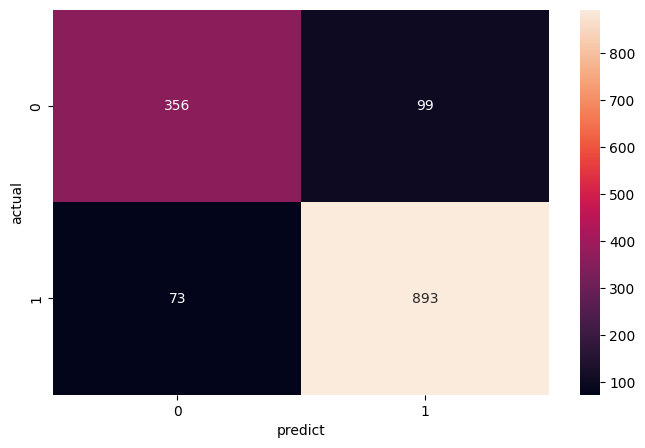

In [8]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
confusion_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print('Confusion Matrix : ') 
print(confusion_matrix)
print('\n Report : ') 
print(classification_report(y_test, y_pred))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", ax=ax)
plt.xlabel("predict")
plt.ylabel("actual")
plt.show()